## Principles of Variational Inference

In variational inference, one wants to approximate the true posterior distribution $p(\omega | D)$ with a variational distribution $q_{\theta}(\omega)$. Variational parameters $\theta$ are chosen so that the "distance" between p and q is minimized.

One can use various notions of distance, for instance the KL divergence:
$$
KL (q || p) = E_{q}[\log{q(\omega)} - \log{p(\omega | D)}] = \int q(\omega) \log{\frac{q(\omega)}{p(\omega | D)}} d\omega
$$
<br>
or the alpha-divergence:
$$D_{\alpha}(p || q) = \frac{1}{\alpha (1-\alpha)} \left( 1-\int p(\omega)^{\alpha} q(\omega)^{1-\alpha} d\omega \right)$$
When $\alpha \rightarrow 0$, this is equivalent to the KL divergence.
<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQ_in_ML.general_utils import *

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Define the necessary distributions
def log_gaussian(omega, params):
    """univariate gaussian or independent gaussians"""
    mus = np.array(params[0:len(params)//2]).reshape((-1,))
    stds = np.array(params[len(params)//2:]).reshape((-1,))
    log2pi = np.log(2 * np.pi)
    log_gauss = 0
    for i in range(len(mus)):
        log_gauss += - 0.5*log2pi - np.log(stds[i]) - 0.5*((omega[:, i]-mus[i])/stds[i])**2
    return log_gauss
def gaussian(omega, params):
    return np.exp(log_gaussian(omega, params))

from scipy.special import loggamma
def log_student(omega, params):
    """univariate t-student or independent t-students"""
    mus = np.array(params[0:len(params)//3]).reshape((-1,))
    stds = np.array(params[len(params)//3:2*len(params)//3]).reshape((-1,))
    nus = np.array(params[2*len(params)//3:]).reshape((-1,))
    log_pdf = 0
    for i in range(len(mus)):
        tmp = loggamma((nus[i]+1)/2) - loggamma(nus[i]/2) - 0.5*np.log(nus[i]*np.pi) - np.log(stds[i])
        log_pdf += tmp - (nus[i]+1)/2 * np.log(1 + 1/nus[i]*((omega[:,i]-mus[i])/stds[i])**2)
    return log_pdf
def student(omega, params):
    return np.exp(log_student(omega, params))

def univariate_gaussian_mixture(omega, mus, stds, pis):
    pdf = 0
    for i, pi in enumerate(pis):
        pdf += pi * gaussian(omega, [mus[i], stds[i]])
    return pdf

def log_bivariate_gaussian(omega, mu1, mu2, std1, std2, rho):
    z = ((omega[:,0]-mu1)/std1)**2 - 2*rho*(omega[:,0]-mu1)*(omega[:,1]-mu2)/(std1*std2) + ((omega[:,1]-mu2)/std2)**2
    log_term1 = -0.5*np.log(1-rho**2) - np.log(2 * np.pi * std1*std2)
    return log_term1 - 0.5 * z / (1-rho**2)
def bivariate_gaussian(omega, mu1, mu2, std1, std2, rho):
    return np.exp(log_bivariate_gaussian(omega, mu1, mu2, std1, std2, rho))

In [3]:
# Define distances, p is bimodal with fixed parameters, q is Gaussian
from scipy.integrate import quad, dblquad

# integrands for computation of KL divergence
def integrand_kl_1d(omega1, params_q, p, q, logq):
    omega = np.array(omega1).reshape((1,1))
    return q(omega, params_q) * (logq(omega, params_q) - np.log(p(omega)))
def integrand_kl_2d(omega1, omega2, params_q, p, q, logq):
    omega = np.array([omega1, omega2]).reshape((1,2))
    return q(omega, params_q) * logq(omega, params_q) - q(omega, params_q) * np.log(p(omega))

# integrands for computation of alpha-divergence 
def integrand_alpha_1d(omega1, params_q, p, q, alpha):
    omega = np.array(omega1).reshape((1,1))
    return p(omega) ** alpha * q(omega, params_q) ** (1-alpha)
def integrand_alpha_2d(omega1, omega2, params_q, p, q, alpha):
    omega = np.array([omega1, omega2]).reshape((1,2))
    return p(omega) ** alpha * q(omega, params_q) ** (1-alpha)
    
# compute distance
def compute_distance(params_q, p, q, logq, alpha, dimension, distance_type):
    if dimension == 1:
        lb = params_q[0]-3.5*params_q[1]
        ub = params_q[0]+3.5*params_q[1]
    if dimension == 2:
        lb1 = params_q[0]-3.5*params_q[2]
        ub1 = params_q[0]+3.5*params_q[2]
        lb2 = params_q[1]-3.5*params_q[3]
        ub2 = params_q[1]+3.5*params_q[3]
    # KL divergence (requires logq)
    if 'kl' in distance_type.lower() and logq is None:
        logq = lambda omega, params: np.log(q(omega, params))
    if 'kl' in distance_type.lower() and dimension == 1:
        return quad(integrand_kl_1d, lb, ub, args=(params_q, p, q, logq))[0]
    elif 'kl' in distance_type.lower() and dimension == 2:
        return dblquad(integrand_kl_2d, lb2, ub2, lambda x: lb1, lambda x: ub1, args=(params_q, p, q, logq))[0]
    # alpha-divergence
    elif 'alpha' in distance_type.lower() and dimension == 1:
        return 1/(alpha*(1-alpha))*(1 - quad(integrand_alpha_1d, lb, ub, args=(params_q, p, q, alpha))[0])
    elif 'alpha' in distance_type.lower() and dimension == 2:
        return 1/(alpha*(1-alpha))*(1 - dblquad(integrand_alpha_2d, lb2, ub2, lambda x: lb1, lambda x: ub1, args=(params_q, p, q, alpha))[0])

In [4]:
# set optimization procedure to find parameters mu_q, std_q that minimize the distances
from scipy.optimize import minimize
def minimize_distance(p, q, distance_type, alpha=None, n_iter=5, bounds=None, logq=None, method='Nelder-Mead',
                      dimension=1, n_params_q=2, verbose=False):
    args = (p, q, logq, alpha, dimension, distance_type)
    fun_iters, params_iters = [], []
    for _ in range(n_iter):
        if n_params_q == 2:
            x0_ = np.concatenate([np.random.uniform(low=-5, high=5, size=(dimension, 1)), 
                                  np.random.uniform(low=0.5, high=2, size=(dimension, 1))], axis=0)
        elif n_params_q == 3:  # for t-student distribution
            x0_ = np.concatenate([np.random.uniform(low=-5, high=5, size=(dimension, 1)), 
                                  np.random.uniform(low=0.5, high=2, size=(dimension, 1)),
                                  np.random.uniform(low=20, high=60, size=(dimension, 1))], axis=0)
        res = minimize(compute_distance, args = args, x0=x0_, bounds=bounds, method=method, 
                       options={'disp': verbose, 'maxiter': 500, 'maxfev': 1000})
        fun_iters.append(res.fun)
        params_iters.append(res.x)
    ind = np.nanargmin(fun_iters)
    return params_iters[ind]

### Make sure it works when p is univariate Gaussian, or bivariate Gaussian without correlation

[3.01256428e-05 1.20369179e+00]
[-2.96834433e-05  1.20367699e+00]
[2.67833686e-05 1.47324174e+00]


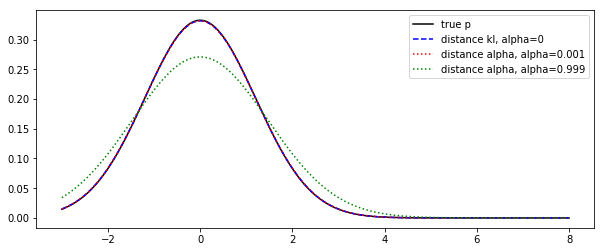

In [6]:
def gaussian_fixed(x):
    mu1=0; std1=1.2
    return gaussian(x, [mu1, std1])

fig, ax = plt.subplots(ncols=1, figsize=(10, 4))
x=np.linspace(-3, 8, 200).reshape((-1,1))
ax.plot(x, gaussian_fixed(x), label='true p', color='black')

distances = ['kl', 'alpha', 'alpha']
alphas = [0, 0.001, 0.999]
colors = ['blue', 'red', 'green']
linestyles = ['--', ':', ':']
# run the optimization problem
for i in range(3):
    res = minimize_distance(p=gaussian_fixed, q=gaussian, distance_type=distances[i], alpha=alphas[i], 
                            n_iter=4, bounds=None, logq=log_gaussian, method='Nelder-Mead')
    ax.plot(x, gaussian(x, res), color=colors[i], linestyle=linestyles[i],
            label='distance '+distances[i]+', alpha={}'.format(alphas[i]))
    print(res)
ax.legend()
plt.show(fig)

true params:
[0, 0, 1.2, 0.8]
Optimization terminated successfully.
         Current function value: -0.000019
         Iterations: 173
         Function evaluations: 292
Optimization terminated successfully.
         Current function value: -0.000019
         Iterations: 179
         Function evaluations: 305
Optimization terminated successfully.
         Current function value: -0.000019
         Iterations: 185
         Function evaluations: 313
params for distance kl, alpha=0
[1.35031440e-05 1.09932136e-05 1.20371414e+00 8.02457220e-01]
Optimization terminated successfully.
         Current function value: 0.931212
         Iterations: 141
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: 0.931212
         Iterations: 123
         Function evaluations: 209
Optimization terminated successfully.
         Current function value: 0.931212
         Iterations: 133
         Function evaluations: 227
params for distance alpha, alpha=

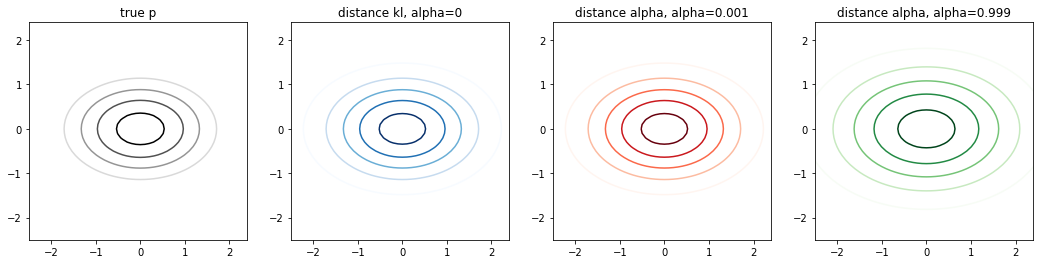

In [6]:
mu1=0; std1=1.2; mu2=0; std2=0.8
def gaussian_fixed(x):
    return gaussian(x, [mu1, mu2, std1, std2])

fig, ax = plt.subplots(ncols=4, figsize=(18, 4))
x, y = np.mgrid[-2.5:2.5:.1, -2.5:2.5:.1]
X = np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=-1)
ax[0].contour(x, y, gaussian_fixed(X).reshape(x.shape), 5, cmap='Greys')
ax[0].set_title('true p')
print('true params:')
print([mu1, mu2, std1, std2])

distances = ['kl', 'alpha', 'alpha']
alphas = [0, 0.001, 0.999]
cmapss = ['Blues', 'Reds', 'Greens']
# run the optimization problem
for i in range(3):
    res = minimize_distance(dimension=2, p=gaussian_fixed, q=gaussian, distance_type=distances[i], alpha=alphas[i], 
                            n_iter=3, bounds=None, logq=log_gaussian, method='Nelder-Mead', verbose=True)
    ax[i+1].contour(x, y, gaussian(X, res).reshape(x.shape), 5, cmap=cmapss[i])
    ax[i+1].set_title('distance '+distances[i]+', alpha={}'.format(alphas[i]))
    print('params for '+'distance '+distances[i]+', alpha={}'.format(alphas[i]))
    print(res)
plt.show(fig)

### Example with univariate Gaussian mixture 

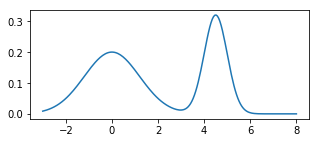

In [7]:
def gaussian_mixture_fixed(x):
    mu1=0; mu2=4.5; std1=1.2; std2=0.5; pi1=0.6
    return univariate_gaussian_mixture(x, [mu1, mu2], [std1, std2], [pi1, 1 - pi1])

fig, ax = plt.subplots(ncols=1, figsize=(5, 2))
x=np.linspace(-3, 8, 200).reshape((-1,1))
#ax.plot(x, gaussian(x, mu1, std1))
ax.plot(x, gaussian_mixture_fixed(x))
plt.show(fig)

NameError: name 'gaussian_mixture_fixed' is not defined

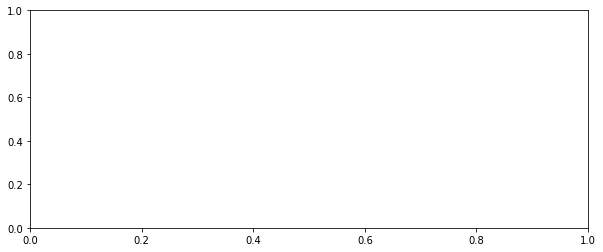

In [7]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 4))
x=np.linspace(-3, 8, 200).reshape((-1,1))
ax.plot(x, gaussian_mixture_fixed(x), label='true p', color='black')

distances = ['kl', 'alpha', 'alpha']
alphas = [0, 0.001, 0.999]
colors = ['blue', 'red', 'green']
linestyles = ['-', '--', '--']
# run the optimization problem
for i in range(3):
    res = minimize_distance(p=gaussian_mixture_fixed, q=gaussian, distance_type=distances[i], alpha=alphas[i], 
                            n_iter=10, bounds=None, logq=log_gaussian)
    ax.plot(x, gaussian(x, res), color=colors[i], linestyle=linestyles[i],
            label='distance '+distances[i]+', alpha={}'.format(alphas[i]))
    print(res)
ax.legend()
plt.show(fig)

### Example with three modes

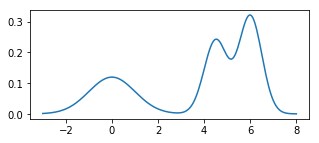

In [8]:
def gaussian_mixture_fixed(x):
    mu1=0; mu2=4.5; mu3=6; std1=1; std2=0.5; std3=0.5; pi1=0.3; pi2=0.3; pi3=0.4
    return univariate_gaussian_mixture(x, [mu1, mu2, mu3], [std1, std2, std3], [pi1, pi2, pi3])

fig, ax = plt.subplots(ncols=1, figsize=(5, 2))
x=np.linspace(-3, 8, 200).reshape((-1,1))
#ax.plot(x, gaussian(x, mu1, std1))
ax.plot(x, gaussian_mixture_fixed(x))
plt.show(fig)

[5.31060167 0.87820393]
[5.31063027 0.87825831]
[3.74948402 2.62479368]


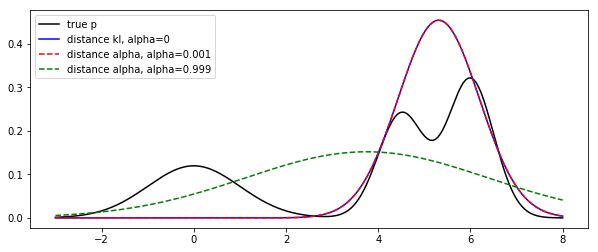

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 4))
x=np.linspace(-3, 8, 200).reshape((-1,1))
ax.plot(x, gaussian_mixture_fixed(x), label='true p', color='black')

distances = ['kl', 'alpha', 'alpha']
alphas = [0, 0.001, 0.999]
colors = ['blue', 'red', 'green']
linestyles = ['-', '--', '--']
# run the optimization problem
for i in range(3):
    res = minimize_distance(p=gaussian_mixture_fixed, q=gaussian, distance_type=distances[i], alpha=alphas[i], 
                            n_iter=10, bounds=None, logq=log_gaussian, method='Nelder-Mead')
    ax.plot(x, gaussian(x, res), color=colors[i], linestyle=linestyles[i],
            label='distance '+distances[i]+', alpha={}'.format(alphas[i]))
    print(res)
ax.legend()
plt.show(fig)

[5.31061825 0.87820539]
[3.72667451 2.60700516]


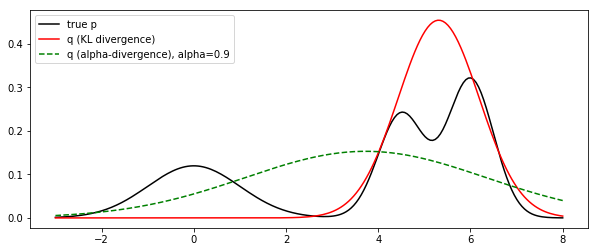

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 4))
x=np.linspace(-3, 8, 200).reshape((-1,1))
ax.plot(x, gaussian_mixture_fixed(x), label=r'true $p(\omega)$', color='black')

distances = ['kl', 'alpha']
titles = [r'$q(\omega)$, from KL divergence', r'$q(\omega)$, from $\alpha$-divergence ($\alpha=0.9$)']
alphas = [0, 0.9]
colors = ['red', 'green']
linestyles = ['-', '--', '--']
# run the optimization problem
for i in range(2):
    res = minimize_distance(p=gaussian_mixture_fixed, q=gaussian, distance_type=distances[i], alpha=alphas[i], 
                            n_iter=10, bounds=None, logq=log_gaussian, method='Nelder-Mead')
    ax.plot(x, gaussian(x, res), color=colors[i], linestyle=linestyles[i],
            label=titles[i])
    ax.set_xlabel(r'$\omega$', fontsize=12); ax.set_ylabel('pdf', fontsize=12)
    print(res)
ax.legend(prop={'size': 12})
plt.show(fig)

### Example with dependent bivariate Gaussian

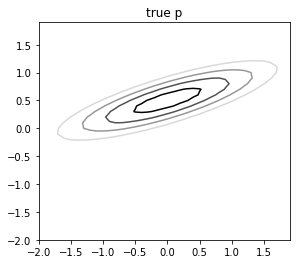

In [11]:
mu1=0; std1=1.2; mu2=0.5; std2=0.5; rho=0.8
def gaussian_fixed(x):
    return bivariate_gaussian(x, mu1, mu2, std1, std2, rho)
fig, ax = plt.subplots(ncols=1, figsize=(4.5, 4))
x, y = np.mgrid[-2:2:.1, -2:2:.1]
X = np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=-1)
ax.contour(x, y, gaussian_fixed(X).reshape(x.shape), 5, cmap='Greys')
ax.set_title('true p')
plt.show()

true params:
[0, 0.5, 1.2, 0.5]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


Optimization terminated successfully.
         Current function value: 0.510332
         Iterations: 168
         Function evaluations: 279
Optimization terminated successfully.
         Current function value: 0.510332
         Iterations: 165
         Function evaluations: 281
Optimization terminated successfully.
         Current function value: 0.510332
         Iterations: 194
         Function evaluations: 333
params for distance kl, alpha=None
[-4.11212939e-05  4.99992954e-01  7.22217441e-01  3.00914300e-01]
Optimization terminated successfully.
         Current function value: 0.616988
         Iterations: 176
         Function evaluations: 295
Optimization terminated successfully.
         Current function value: 0.616988
         Iterations: 173
         Function evaluations: 300
Optimization terminated successfully.
         Current function value: 0.616988
         Iterations: 182
         Function evaluations: 311
params for distance alpha, alpha=0.999
[2.13449813e-05 5.00

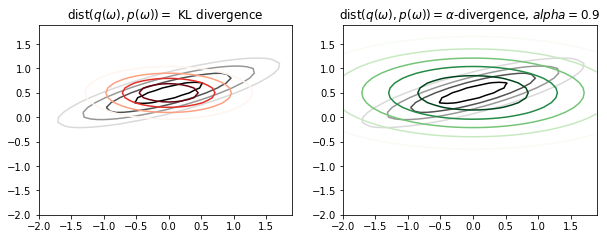

In [15]:
mu1=0; std1=1.2; mu2=0.5; std2=0.5; rho=0.8
def gaussian_fixed(x):
    return bivariate_gaussian(x, mu1, mu2, std1, std2, rho)

fig, ax = plt.subplots(ncols=2, figsize=(10, 3.5))
x, y = np.mgrid[-2:2:.1, -2:2:.1]
X = np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=-1)
ax[0].contour(x, y, gaussian_fixed(X).reshape(x.shape), 5, cmap='Greys')
ax[0].set_title('true p')
ax[1].contour(x, y, gaussian_fixed(X).reshape(x.shape), 5, cmap='Greys')
ax[1].set_title('true p')
print('true params:')
print([mu1, mu2, std1, std2])

distances = ['kl', 'alpha']
alphas = [None, 0.999]
cmapss = ['Reds', 'Greens']
titles = [r'dist$(q(\omega),p(\omega)) =$ KL divergence', 
          r'dist$(q(\omega),p(\omega)) = \alpha$-divergence, $\alpha=0.9$']
# run the optimization problem
for i in range(2):
    res = minimize_distance(dimension=2, p=gaussian_fixed, q=gaussian, distance_type=distances[i], alpha=alphas[i], 
                            n_iter=3, bounds=None, logq=log_gaussian, method='Nelder-Mead', verbose=True)
    ax[i].contour(x, y, gaussian(X, res).reshape(x.shape), 5, cmap=cmapss[i])
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].set_xlabel(r'$\omega_{1}$', fontsize=12); ax[i].set_ylabel(r'$\omega_{2}$', fontsize=12)
    print('params for '+'distance '+distances[i]+', alpha={}'.format(alphas[i]))
    print(res)
plt.show(fig)

In [14]:
print(r'dist$(q(\omega),p(\omega)) =$ KL divergence')

dist$(q(\omega),p(\omega)) =$ KL divergence


true params:
[0, 0.5, 1.2, 0.5]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


Optimization terminated successfully.
         Current function value: 0.510332
         Iterations: 187
         Function evaluations: 315
Optimization terminated successfully.
         Current function value: 0.510332
         Iterations: 163
         Function evaluations: 284


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:563: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


params for distance kl, alpha=0
[-1.16279121e-05  5.00008048e-01  7.22233355e-01  3.00923627e-01]
Optimization terminated successfully.
         Current function value: 1.441623
         Iterations: 167
         Function evaluations: 294
Optimization terminated successfully.
         Current function value: 1.441623
         Iterations: 186
         Function evaluations: 305
Optimization terminated successfully.
         Current function value: 1.441623
         Iterations: 155
         Function evaluations: 262
params for distance alpha, alpha=0.001
[1.89100601e-05 4.99996650e-01 7.22437022e-01 3.01013017e-01]
Optimization terminated successfully.
         Current function value: 0.616988
         Iterations: 232
         Function evaluations: 396
Optimization terminated successfully.
         Current function value: 0.616988
         Iterations: 101
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: 0.616988
         Iterations: 

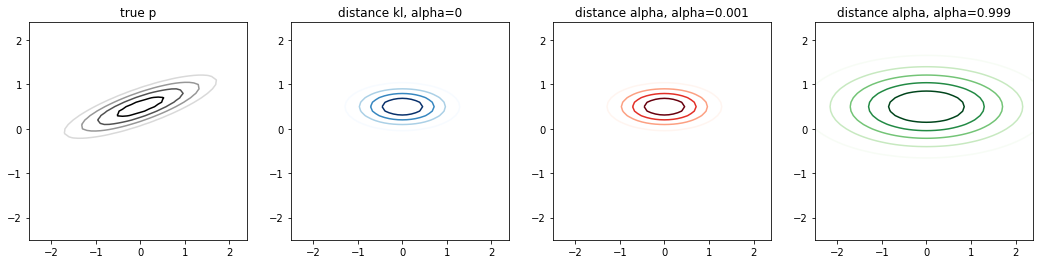

In [12]:
mu1=0; std1=1.2; mu2=0.5; std2=0.5; rho=0.8
def gaussian_fixed(x):
    return bivariate_gaussian(x, mu1, mu2, std1, std2, rho)

fig, ax = plt.subplots(ncols=4, figsize=(18, 4))
x, y = np.mgrid[-2.5:2.5:.1, -2.5:2.5:.1]
X = np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=-1)
ax[0].contour(x, y, gaussian_fixed(X).reshape(x.shape), 5, cmap='Greys')
ax[0].set_title('true p')
print('true params:')
print([mu1, mu2, std1, std2])

distances = ['kl', 'alpha', 'alpha']
alphas = [0, 0.001, 0.999]
cmapss = ['Blues', 'Reds', 'Greens']
# run the optimization problem
for i in range(3):
    res = minimize_distance(dimension=2, p=gaussian_fixed, q=gaussian, distance_type=distances[i], alpha=alphas[i], 
                            n_iter=3, bounds=None, logq=log_gaussian, method='Nelder-Mead', verbose=True)
    ax[i+1].contour(x, y, gaussian(X, res).reshape(x.shape), 5, cmap=cmapss[i])
    ax[i+1].set_title('distance '+distances[i]+', alpha={}'.format(alphas[i]))
    print('params for '+'distance '+distances[i]+', alpha={}'.format(alphas[i]))
    print(res)
plt.show(fig)

## Try the bimodal one, learning q as a t-student instead of a gaussian

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


[0.57883451 1.37346119 0.08860502]
[6.64022873e-01 1.83725643e+00 3.46702838e+06]
[1.79923397e+00 2.41364114e+00 9.29892592e+06]


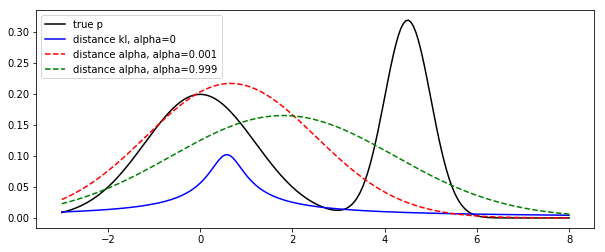

In [13]:
def gaussian_mixture_fixed(x):
    mu1=0; mu2=4.5; std1=1.2; std2=0.5; pi1=0.6
    return univariate_gaussian_mixture(x, [mu1, mu2], [std1, std2], [pi1, 1 - pi1])

fig, ax = plt.subplots(ncols=1, figsize=(10, 4))
x=np.linspace(-3, 8, 200).reshape((-1,1))
ax.plot(x, gaussian_mixture_fixed(x), label='true p', color='black')

distances = ['kl', 'alpha', 'alpha']
alphas = [0, 0.001, 0.999]
colors = ['blue', 'red', 'green']
linestyles = ['-', '--', '--']
# run the optimization problem
for i in range(3):
    res = minimize_distance(p=gaussian_mixture_fixed, q=student, distance_type=distances[i], alpha=alphas[i], 
                            n_iter=5, bounds=None, logq=log_student, n_params_q = 3)
    ax.plot(x, student(x, res), color=colors[i], linestyle=linestyles[i],
            label='distance '+distances[i]+', alpha={}'.format(alphas[i]))
    print(res)
ax.legend()
plt.show(fig)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


[0.57891163 1.37349053 0.08860414]
[0.65989108 1.83556617]


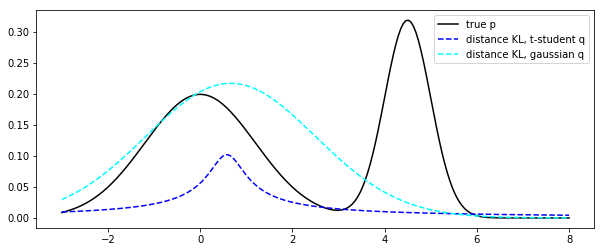

In [14]:
def gaussian_mixture_fixed(x):
    mu1=0; mu2=4.5; std1=1.2; std2=0.5; pi1=0.6
    return univariate_gaussian_mixture(x, [mu1, mu2], [std1, std2], [pi1, 1 - pi1])

fig, ax = plt.subplots(ncols=1, figsize=(10, 4))
x=np.linspace(-3, 8, 200).reshape((-1,1))
ax.plot(x, gaussian_mixture_fixed(x), label='true p', color='black')

# run the optimization problem
res = minimize_distance(p=gaussian_mixture_fixed, q=student, distance_type='kl', alpha=None, 
                        n_iter=5, bounds=None, logq=log_student, n_params_q = 3)
ax.plot(x, student(x, res), color='blue', linestyle=linestyles[i],
        label='distance KL, t-student q')
print(res)
res = minimize_distance(p=gaussian_mixture_fixed, q=gaussian, distance_type='kl', alpha=None, 
                        n_iter=5, bounds=None, logq=log_gaussian, n_params_q = 2)
ax.plot(x, gaussian(x, res), color='cyan', linestyle=linestyles[i],
        label='distance KL, gaussian q')
print(res)
ax.legend()
plt.show(fig)

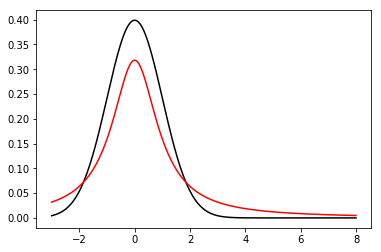

In [15]:
x=np.linspace(-3, 8, 200).reshape((-1,1))
plt.plot(x, gaussian(x, [0, 1]), label='true p', color='black')
plt.plot(x, student(x, [0, 1, 1]), label='true p', color='red')